# 根据dSdEta处在3.0<|eta|<5.4之间的积分结果重新划分中心度

### trento输出的mult值只是按照trento的计算方法得到最中心eta=0处的熵密度分布
### 我们不能按照这个mult值去对中心度进行划分。
### 因为我们的熵密度分布形式相较于Trento已经发生了改变，需要重新划分中心度

### trento中：

### $$f = T_{R}\left(p; T_{A}, T_{B}\right) \equiv \left(\frac{T_{A}^{p} + T_{B}^{p}}{2}\right)^{1/p}$$

### $$T_R = 
\begin{cases} 
\max(T_A, T_B), & p \rightarrow +\infty \\
(T_A + T_B)/2, & p = +1 \text{ (arithmetic)} \\
\sqrt{T_A T_B}, & p = 0 \text{ (geometric)} \\
2T_A T_B / (T_A + T_B), & p = -1 \text{ (harmonic)} \\
\min(T_A, T_B), & p \rightarrow -\infty.
\end{cases}$$

In [1]:
import numpy as np
# import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.integrate import simpson, trapezoid
# from IPython.display import Image

import mplhep as hep
hep.style.use('ATLAS')

import os
# from tqdm import tqdm
# import h5py
from concurrent.futures import ProcessPoolExecutor, as_completed


# 定义计算熵密度分布的类：dSdEtaCalculator

In [2]:
class dSdEtaCalculator:
    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3,y_loss=0.5, 
                 P_factor=1, L_factor=1, R_factor=1, alpha=2.0,beta=0.5):
        
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor     # 添加 L_factor 参数，提高高斯分布的高度
        self.R_factor = R_factor     # 添加 R_factor 参数，提高高斯分布的高度
        self.P_factor = P_factor     # 添加 P_factor 参数，提高平台分布的高度
        self.alpha = alpha           # 添加 alpha 参数，改变熵密度的形式
        self.beta = beta             # 添加 beta 参数，改变熵密度的形式
        self.eta_flat = eta_flat     # 添加 eta_flat 参数，改变熵密度的形式
        self.eta_gw = eta_gw         # 添加 eta_gw 参数，改变熵密度的形式
        self.y_loss = y_loss

        self.coef_L, self.coef_R, self.coef_LR = self.save_longitudinal_dis_coef()
    
    # 定义使用gaussian 和plateau形式
    def gaussian_function(self, x=0, center=0, width=1):
        """
        定义一个标准的高斯分布函数。

        参数:
        x: 自变量，可以是单个值或数组
        center: 高斯分布的中心位置
        width: 高斯分布的宽度（标准差）

        返回值:
        高斯分布在 x 位置的值
        """
        return np.exp(-((x - center)**2) / (2 * width**2))
    
    def plateau_function(self, eta=np.linspace(-6.9,6.9,121)):
        """
        定义一个带有平台分布的函数
        eta: 输入的自变量数组
        eta_flat: 平台区域的范围，eta 绝对值小于 eta_flat 时函数输出1
        eta_gw: 控制衰减的宽度参数
        """
        # 初始化函数值，全为1
        heta = np.ones_like(eta)

        # 找到进入衰减区域的位置
        fall_off = np.abs(eta) > self.eta_flat

        # 对进入衰减区域的eta值计算其衰减部分
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat)**2 / (2.0 * self.eta_gw**2))

        return heta

    # 计算左右分布函数的离散化值
    def save_longitudinal_dis_coef(self):
        """Calculate and return f_L and f_R coefficients."""
        etas = np.linspace(-self.eta, self.eta, self.slices)
        
        # 添加 LR_factor 参数，提高高斯分布的高度
        coef_l = self.L_factor * self.gaussian_function(x=etas, center=self.y_0-self.y_loss, width=self.sigma) # L
        coef_r = self.R_factor * self.gaussian_function(x=etas, center=-self.y_0, width=self.sigma)            # R
        coef_lr = self.P_factor * self.plateau_function(eta=etas)                                     # Platform
        return coef_l, coef_r, coef_lr
    
#### 使用计算好的三个 entropy2D 计算dSdEta再求和计算总分布 ################    
    # 计算 d 或 Au 的各自的能量密度
    def calc_dSdEta_part(self, entropy_200x200, coef_list):
        """
        Multiply a 200x200 matrix with a 121-element list and return a 121x200x200 array.
        """
        dtau0 = 0.6
        dx = 0.16
        dy = 0.16
        deta = 0.115
        dtau = dtau0 * dx * dy * deta
        dSdEta_half = np.zeros(len(coef_list)) # shape(121,)
        
        for i, coef in enumerate(coef_list):
            dSdEta_half[i] = np.sum(entropy_200x200) * dtau * coef
        return dSdEta_half

    # 计算总能量密度分布  
    def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R):
        """Calculate the combined entropy."""
        entropy2d_plat = entropy_200x200_L * entropy_200x200_R
      
        dSdEta_L  = self.calc_dSdEta_part(entropy_200x200_L**self.alpha, self.coef_L)
        dSdEta_R  = self.calc_dSdEta_part(entropy_200x200_R**self.alpha, self.coef_R)
        dSdEta_LR = self.calc_dSdEta_part(entropy2d_plat**self.beta, self.coef_LR)  # 添加平台区域
         
        dSdEta = dSdEta_L + dSdEta_R + dSdEta_LR
        return dSdEta

##### 使用计算好的 entropy3D 计算dSdEta ################################    
#     def calc_dSdEta_slice(self, entropy3D):
#         dtau0 = 0.6
#         dx = 0.16
#         dy = 0.16
#         deta = 0.115
#         dtau = dtau0 * dx * dy * deta

#         dSdEta = np.zeros(self.slices)
#         for i in range(self.slices):
#             dSdEta[i] = np.sum(entropy3D[i]) * dtau
#         return dSdEta

#     def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R):
#         entropy3D = self.calc_entropy3D(entropy_200x200_L, entropy_200x200_R)
#         return self.calc_dSdEta_slice(entropy3D)


# 并行化计算熵密度分布

In [3]:
def calculate_event_dSdEta(event, input_dir, calculator):
    """计算单事件的 dSdEta 值"""
    projectile_file = os.path.join(input_dir, f'projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'target_entropy_event_{event}.dat')
    
    if os.path.exists(projectile_file) and os.path.exists(target_file):
        # 读取数据
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)
        
        # 计算 dSdEta
        dSdEta = calculator.calc_dSdEta(sum_gaussian_L, sum_gaussian_R)
        return dSdEta
    else:
        print(f"Warning: Files for event {event} not found.")
        return None



def calc_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                         eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                         L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                         HWF_or_DWF='HWF', num_workers=4):
    """
    逐事件并行计算 dSdEta，将结果保存为数组，并绘图。
    
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param m, n: 中心度范围
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param save_dir: 保存结果的目录
    """

    # 实例化计算器
    calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
    input_dir = (f'/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta 和事件序号
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 保存 dSdEta 和事件序号
                    dSdEta_event_all.append([dSdEta_result, event])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)
    dSdEta_event_list = dSdEta_event_array[np.argsort(dSdEta_event_array[:, 1])]

    # 绘图
    plt.figure(figsize=(8, 6))
    eta_values = np.linspace(-eta, eta, slices)

    for dSdEta, event in dSdEta_event_list:
        plt.plot(eta_values, dSdEta, label=f'Event {event}', alpha=0.6)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'$\rm dS/d\eta$ Distribution'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}', fontsize=20)
    plt.legend(fontsize=12, loc='upper right', ncol=1)
    plt.grid()
#     plt.tight_layout()
    return dSdEta_event_array


### 逐trento初态事件画熵密度分布，中心度与事件之间是散乱的

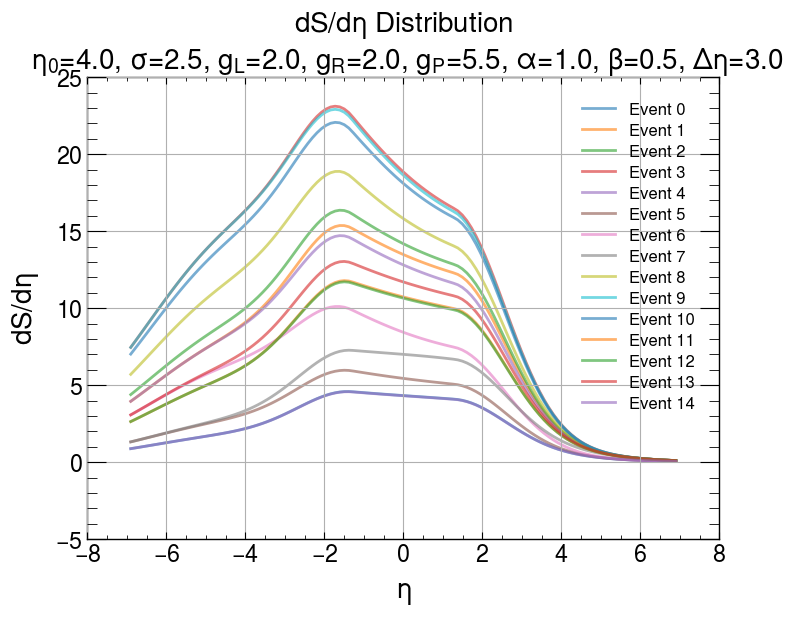

In [4]:
dSdEta_ebe = calc_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 15],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='DWF', num_workers=4)

In [5]:
dSdEta_ebe

array([[array([0.88218465, 0.93025986, 0.97898407, 1.02821086, 1.07779115,
               1.12757643, 1.17742257, 1.22719428, 1.2767702 , 1.32604872,
               1.37495436, 1.42344478, 1.4715182 , 1.51922112, 1.56665598,
               1.61398859, 1.66145475, 1.70936567, 1.75811149, 1.8081625 ,
               1.86006708, 1.914446  , 1.97198226, 2.03340612, 2.09947481,
               2.17094701, 2.24855215, 2.33295499, 2.42471654, 2.52425251,
               2.63179085, 2.74733066, 2.87060445, 3.00104635, 3.13776875,
               3.27954964, 3.42483261, 3.57174123, 3.71810857, 3.86152202,
               3.99938269, 4.1289778 , 4.24756339, 4.35245433, 4.44111736,
               4.51126318, 4.56093278, 4.58857378, 4.59310277, 4.57505978,
               4.55140058, 4.52798168, 4.50485261, 4.48204831, 4.45958952,
               4.43748339, 4.41572431, 4.39429489, 4.3731671 , 4.35230352,
               4.33165873, 4.31118074, 4.29081248, 4.27049329, 4.25016052,
               4.2297509 

# 按照处在 3.0 < |eta| < 5.4范围的总熵去划分中心度

In [6]:
def calculate_integral_simpson(dsdeta, etas):
    """计算 dsdeta 在 |etas| 范围 [3.0, 5.4] 内的积分值"""
    

    # 分别计算两个区间的积分
    mask1 = (etas >= -5.4) & (etas <= -3.0)
    mask2 = (etas >= 3.0) & (etas <= 5.4)

    # Simpson 方法
    ds_simpson1 = simpson(dsdeta[mask1], x=etas[mask1])
    ds_simpson2 = simpson(dsdeta[mask2], x=etas[mask2])
    
    integral = ds_simpson1 + ds_simpson2
    return integral

def calculate_integral_trapezoid(dsdeta, etas):
    """计算 dsdeta 在 |etas| 范围 [3.0, 5.4] 内的积分值"""
    
    # 分别计算两个区间的积分
    mask1 = (etas >= -5.4) & (etas <= -3.0)
    mask2 = (etas >= 3.0) & (etas <= 5.4)

    # Simpson 方法
    ds_trapezoid1 = trapezoid(dsdeta[mask1], etas[mask1])
    ds_trapezoid2 = trapezoid(dsdeta[mask2], etas[mask2])
    
    ds_total = ds_trapezoid1 + ds_trapezoid2
    return ds_total
def calculate_integral(dsdeta, etas, method="trapezoid"):
        """
        计算 |etas| 范围 [3.0, 5.4] 内的积分
        """
        mask1 = (etas > -5.4) & (etas < -3.0)
        mask2 = (etas > 3.0) & (etas < 5.4)
        if method == "trapezoid":
            integral_dS = trapezoid(dsdeta[mask1], etas[mask1]) + trapezoid(dsdeta[mask2], etas[mask2])
        elif method == "simpson":
            integral_dS = simpson(dsdeta[mask1], x=etas[mask1]) + simpson(dsdeta[mask2], x=etas[mask2])
        else:
            raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
        return integral_dS
    
def calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                    eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                    HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并绘图。
    
    返回值包含每个事件的 dSdEta, 事件序号，以及ds积分值。
    
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    """

    # 实例化计算器
    calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
#     disk_2T = '74e6f585-9c67-40c0-a5e9-89fb98e77bab'
#     input_dir = (f'/media/mengzhu/{disk_2T}/home/mengzhu/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    input_dir = (f'/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta、事件序号和积分值

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_all.append([dSdEta_result, event, ds_total])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)

    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_array[:, 2])[::-1]
    dSdEta_event_array = dSdEta_event_array[sorted_indices]

    # 绘图
    if plot_dSdEta:
        plt.figure(figsize=(8, 6))
        eta_values = np.linspace(-eta, eta, slices)

        for dSdEta, event, dS in dSdEta_event_array:
            plt.plot(eta_values, dSdEta, label=f'Event {event} (dS ={dS:.2f})', alpha=0.6)

        plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
        plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
        plt.title(r'$\rm dS/d\eta$ Distribution'
                  + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}',fontsize=20)
        plt.legend(fontsize=12, loc='upper right', ncol=1)
        plt.grid()

    return dSdEta_event_array


### 按照熵密度降序，画出按照中心度下降的逐事件熵密度分布

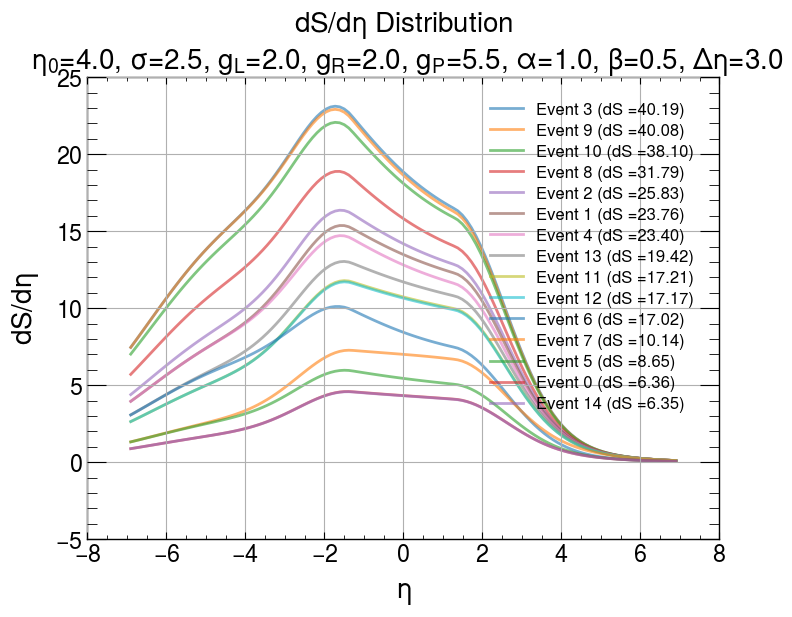

In [7]:
dSdEta_centrality_ebe = calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 15],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='DWF', num_workers=4,plot_dSdEta=True)

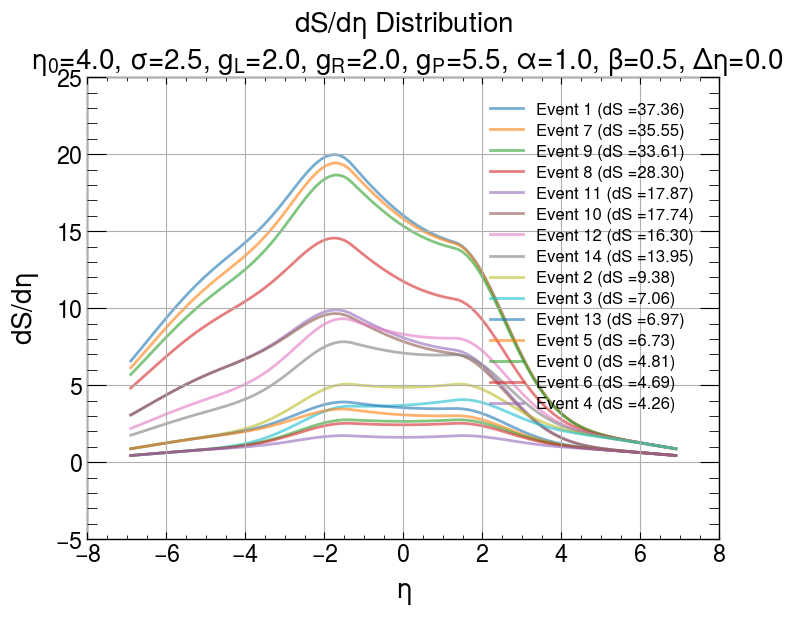

In [8]:
dSdEta_centrality_ebe = calc_plot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                   eta_flat=1.3, eta_gw=1.3, y_loss=0.0, event_range=[0, 15],
                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                   HWF_or_DWF='HWF', num_workers=4,plot_dSdEta=True)

In [9]:
def calc_sub_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                             eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                             L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                             percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                             HWF_or_DWF='HWF', num_workers=4,save_fig=False):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并绘制不同中心度区间的 dSdEta 分布图。
    
    返回值包含每个事件的 dSdEta, 事件序号，以及ds积分值。
    
    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param plot_dSdEta: 是否绘制 dSdEta 分布图
    """
    # 实例化计算器
    calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
    input_dir = (f'/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')


    # 并行计算并保存结果
    dSdEta_event_all = []  # 用于保存 dSdEta、事件序号和积分值

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_all.append([dSdEta_result, event, ds_total])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)


    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_array[:, 2])[::-1]
    dSdEta_event_array = dSdEta_event_array[sorted_indices]

    
    # 计算每个中心度区间并绘图
    eta_values = np.linspace(-eta, eta, slices)
    percentiles = percentiles
    total_events = len(dSdEta_event_array)

    # 创建2行5列的子图
#     fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharey=True) # 共享坐标轴
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    axes = axes.flatten()  # 将 2x4 的数组转换为 1D 数组，便于迭代

    # 设置纵轴统一范围
    # 获取所有事件的 dSdEta 的最小值和最大值
#     all_dSdEta_values = np.concatenate([dSdEta_result[0] for dSdEta_result in dSdEta_event_array])  # 合并所有事件的 dSdEta
#     min_y = np.min(all_dSdEta_values)
#     max_y = np.max(all_dSdEta_values)
#     y_range = (min_y, max_y)
    
    # 对每个中心度区间绘制 dSdEta 分布
    for idx, (start, end) in enumerate(percentiles):
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)

        # 获取当前区间内所有事件的 dSdEta
        for i in range(start_idx, end_idx):
            dSdEta = dSdEta_event_array[i, 0]  # 获取该事件的 dSdEta
            axes[idx].plot(eta_values, dSdEta, alpha=0.6)  # 将该事件的 dSdEta 绘制到相应的子图
        
        # 添加中心度区间作为图例
        axes[idx].plot([], [], linestyle=' ', label=f'{start}-{end}%')  # 空 plot，只用作图例说明
        axes[idx].legend(loc='upper right', fontsize=20)  # 调整图例位置和字体大小
        axes[idx].set_xlabel(r'$\rm \eta$', fontsize=20, ha="center")
        axes[idx].set_ylabel(r'$\rm dS/d\eta$', fontsize=20, ha="center")
#         axes[idx].set_title(f'{start}-{end}', fontsize=18)
#         axes[idx].set_xlim(-eta,eta)  # 设置统一纵轴范围
#         axes[idx].set_ylim(y_range)  # 设置统一纵轴范围
        
        axes[idx].set_xlim(-8,8)  # 设置统一纵轴范围
        axes[idx].set_ylim(0,40)  # 设置统一纵轴范围
        axes[idx].grid(True,alpha=0.3)

    # 隐藏最后一个多余的子图
    axes[-1].axis('off')
#     plt.suptitle(r'$\rm dS/d\eta$ Distribution ' + f'with {HWF_or_DWF}\n'
#                  + f'$\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
#                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}',fontsize=30)
    plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality ',fontsize=30)
    if save_fig:
        plt.savefig(f'fig/dSdeta_ebe_P_factor_{str(P_factor).replace(".", "p")}_beta_{str(beta).replace(".", "p")}.pdf', bbox_inches='tight', pad_inches=0.0)
    plt.tight_layout()
    plt.show()

#     return dSdEta_event_array


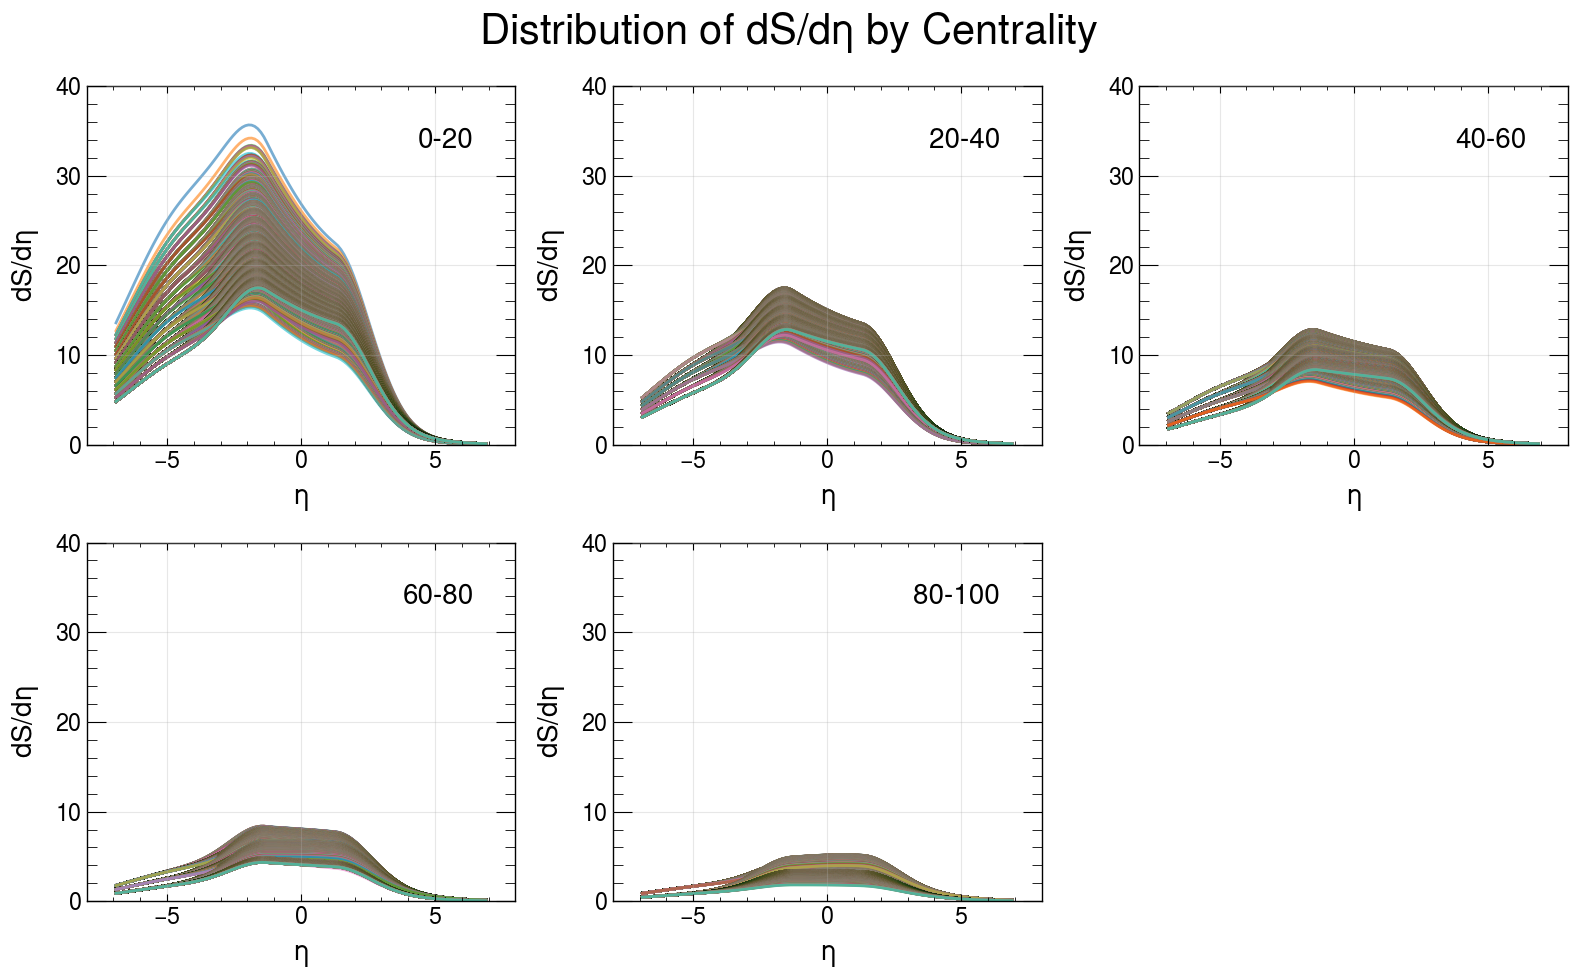

In [10]:
calc_sub_plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                         eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 50000],
                         L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                         percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                         HWF_or_DWF='DWF', num_workers=16,save_fig=False)

In [10]:
def plot_dSdEta_centrality(dSdEta_event_array, eta=6.9, slices=121, 
                           percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                           additional_title=''):
    """
    根据熵密度排序的 dSdEta_event_array 数据，计算指定百分位区间的平均分布并绘图。

    :param dSdEta_event_array: 按熵密度降序排列的事件数组，形状为 (N, 1)，列分别为 dSdEta
    :param eta: 快度范围，用于生成横坐标。
    :param slices: 快度切片个数。
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :param additional_title: 额外的标题信息，用于添加到主标题中。
    """
    # 生成横坐标
    eta_values = np.linspace(-eta, eta, slices)
    
    # 用于存储每个区间的平均分布
    average_distributions = []
    
    # 总事件数
    total_events = len(dSdEta_event_array)
    
    # 计算每个区间的平均 dSdEta 分布
    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        
        # 提取对应区间的 dSdEta 数据
        dSdEta_data = np.array([dSdEta_event_array[i] for i in range(start_idx, end_idx)])
        
        # 计算平均值
        average_distribution = np.mean(dSdEta_data, axis=0)
        average_distributions.append((average_distribution, f'{start}-{end}%'))
    
    # 绘图
    # 统一的颜色
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    plt.figure(figsize=(8, 6))
    color_idx=0
    for avg_dist, label in average_distributions:
        plt.plot(eta_values, avg_dist, color=colors[color_idx],label=f'{label}', alpha=0.8)
        color_idx+=1
    
    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'$\rm dS/d\eta$ Average Distribution '  + additional_title, fontsize=20)
    plt.legend(fontsize=18, loc='upper right')
    plt.grid()
    plt.show()
    plt.tight_layout()
    
    return average_distributions
    
    
def plot_dSdEta_centralities(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                             eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                             L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                             HWF_or_DWF='HWF', num_workers=4,
                             percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并绘制不同中心度区间的平均分布。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """

    # 实例化计算器
    calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

#     # 输入文件路径
#     disk_2T = '74e6f585-9c67-40c0-a5e9-89fb98e77bab'
#     input_dir = (f'/media/mengzhu/{disk_2T}/home/mengzhu/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')
    # 输入文件路径
    disk_2T = 'MZ'
    input_dir = (f'/media/mengzhu/{disk_2T}/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_ds_total = []  # 用于保存 dSdEta、事件序号和积分值

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_ds_total.append([dSdEta_result, event, ds_total])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_ds_total_array = np.array(dSdEta_event_ds_total, dtype=object)

    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_ds_total_array[:, 2])[::-1]
    dSdEta_event_ds_total_array = dSdEta_event_ds_total_array[sorted_indices]
    dSdEta = dSdEta_event_ds_total_array[:, 0]

    # 构建标题附加信息
    additional_title = (
        f'with {HWF_or_DWF}' 
        + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
        + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}')

    # 调用绘制五个中心度区间平均分布的函数
    average_distributions = plot_dSdEta_centrality(dSdEta, eta=eta, slices=slices, percentiles=percentiles, additional_title=additional_title)
    return average_distributions



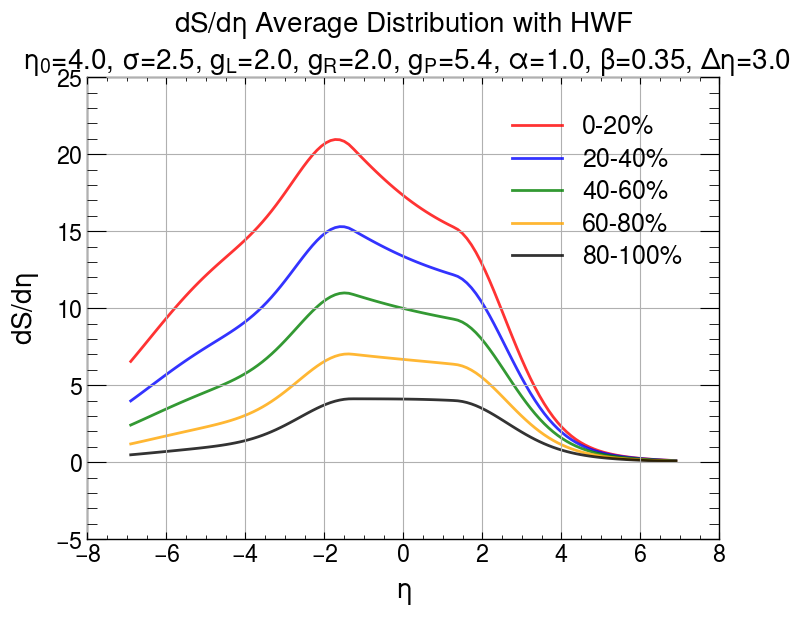

<Figure size 800x600 with 0 Axes>

In [11]:
average_distributions = plot_dSdEta_centralities(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                         eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                         L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.35,
                         percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                         HWF_or_DWF='HWF', num_workers=16)

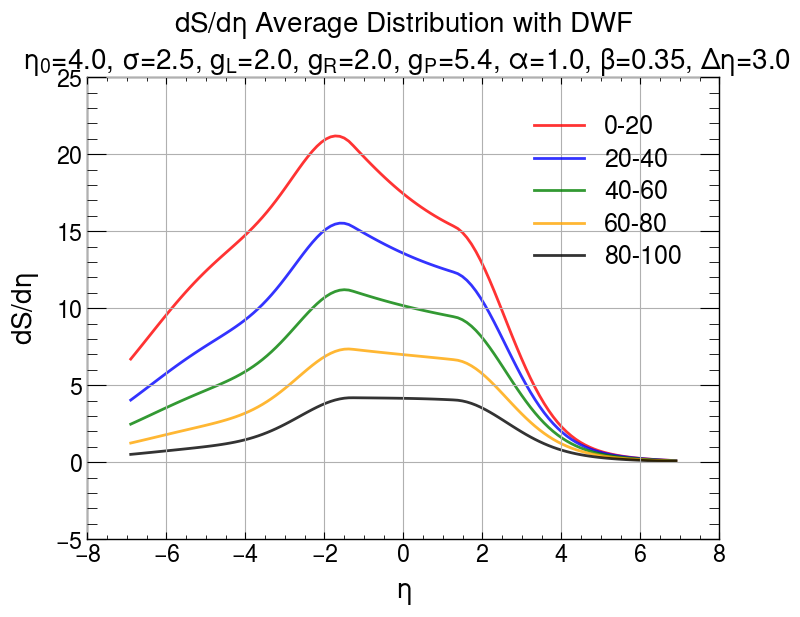

<Figure size 800x600 with 0 Axes>

In [12]:
average_distributions = plot_dSdEta_centralities(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                         eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                         L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.35,
                         percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                         HWF_or_DWF='DWF', num_workers=16)

In [13]:
average_distributions

[(array([ 6.7002191 ,  7.06161731,  7.4270683 ,  7.79529676,  8.16497421,
          8.53473587,  8.90320046,  9.26899321,  9.63077202,  9.98725668,
         10.33726119, 10.67972859, 11.01376794, 11.33869252, 11.65405819,
         11.95970054, 12.2557689 , 12.54275535, 12.82151616, 13.09328315,
         13.35966214, 13.62261594, 13.88442915, 14.14765292, 14.41502812,
         14.68938639, 14.97352997, 15.27009193, 15.58138079, 15.90921426,
         16.25474905, 16.61831451, 16.99925951, 17.39582206, 17.80503171,
         18.22265407, 18.64318553, 19.05990444, 19.46498247, 19.84965668,
         20.20445949, 20.51950009, 20.78478743, 20.99058156, 21.12775797,
         21.18816745, 21.16497372, 21.05295128, 20.84872761, 20.5553845 ,
         20.24148846, 19.93127297, 19.62575533, 19.32584959, 19.03236445,
         18.74600253, 18.46736095, 18.19693306, 17.93511141, 17.68219167,
         17.43837749, 17.20378615, 16.97845485, 16.76234751, 16.555362  ,
         16.35733761, 16.16806262, 15.

In [14]:
# # 提取所有需要的 array
# data = [average_distributions[i][0] for i in range(len(average_distributions))]

# # 合并为二维数组
# data_combined = np.vstack(data)

# # 保存到文件
# np.savetxt("./data/dSdEta_average_distributions.dat", data_combined)
# print("数据已成功保存！")


## 比较 DWF 与 HWF的区别

In [18]:
def plot_dSdEta_DWF_HWF_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                                   cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                   num_workers=16,save_fig=False):
    """
    对比 DWF 和 HWF 参数下的 dS/dEta 平均分布，并将它们绘制在同一张图中。
    """
    def calculate_and_sort(HWF_or_DWF):
        # 计算器
        calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                      y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                      L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)
        
        # 输入文件路径
        input_dir = (f'/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')
        
        # 计算所有事件的 dSdEta
        dSdEta_event_ds_total = []
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                       for event in range(event_range[0], event_range[1])}

            for future in as_completed(futures):
                event = futures[future]
                try:
                    dSdEta_result = future.result()
                    if dSdEta_result is not None:
                        etas = np.linspace(-eta, eta, slices)
                        ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                        dSdEta_event_ds_total.append([dSdEta_result, event, ds_total])
                except Exception as e:
                    print(f"Error processing event {event}: {e}")

        # 排序
        dSdEta_event_ds_total_array = np.array(dSdEta_event_ds_total, dtype=object)
        sorted_indices = np.argsort(dSdEta_event_ds_total_array[:, 2])[::-1]
        dSdEta_event_ds_total_array = dSdEta_event_ds_total_array[sorted_indices]
        return dSdEta_event_ds_total_array[:, 0]  # 返回 dSdEta 数据
    
    # 分别计算 DWF 和 HWF 的结果
    dSdEta_DWF = calculate_and_sort('DWF')
    dSdEta_HWF = calculate_and_sort('HWF')

    # 生成快度坐标
    eta_values = np.linspace(-eta, eta, slices)

    # 绘图
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    plt.figure(figsize=(8, 6))
    color_idx=0
    for start, end in cents:
        # 获取 DWF 和 HWF 的平均分布
        DWF_start_idx = int(len(dSdEta_DWF) * start / 100)
        DWF_end_idx = int(len(dSdEta_DWF) * end / 100)
        avg_DWF = np.mean(dSdEta_DWF[DWF_start_idx:DWF_end_idx], axis=0)
        
        HWF_start_idx = int(len(dSdEta_HWF) * start / 100)
        HWF_end_idx = int(len(dSdEta_HWF) * end / 100)
        avg_HWF = np.mean(dSdEta_HWF[HWF_start_idx:HWF_end_idx], axis=0)
        
        # 绘制 DWF 和 HWF 曲线
        plt.plot(eta_values, avg_DWF, color=colors[color_idx], label=f'DWF {start}-{end}', linestyle='-', alpha=0.8)
        plt.plot(eta_values, avg_HWF, color=colors[color_idx], label=f'HWF {start}-{end}', linestyle='--', alpha=0.8)
        color_idx+=1
        
    # 添加标签和图例
    plt.xlabel(r'$\rm \eta$', fontsize=25, ha='center')
    plt.ylabel(r'Average $\rm dS/d\eta$', fontsize=25, ha='center')
#     plt.title(r'$\rm dS/d\eta$ Average Distribution Comparison with DWF and HWF'
#               + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
#               + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}, $\\rm \\Delta \\eta$={y_loss}', fontsize=20)
#     plt.title(r'Average $\rm dS/d\eta$ Distribution Comparison Between DWF and HWF', fontsize=20)
    # 增大刻度字体
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15, loc='upper right')
#     plt.grid()
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'fig/Average_dSdeta_DWF_HWF_0p35.pdf', bbox_inches='tight')
    plt.show()


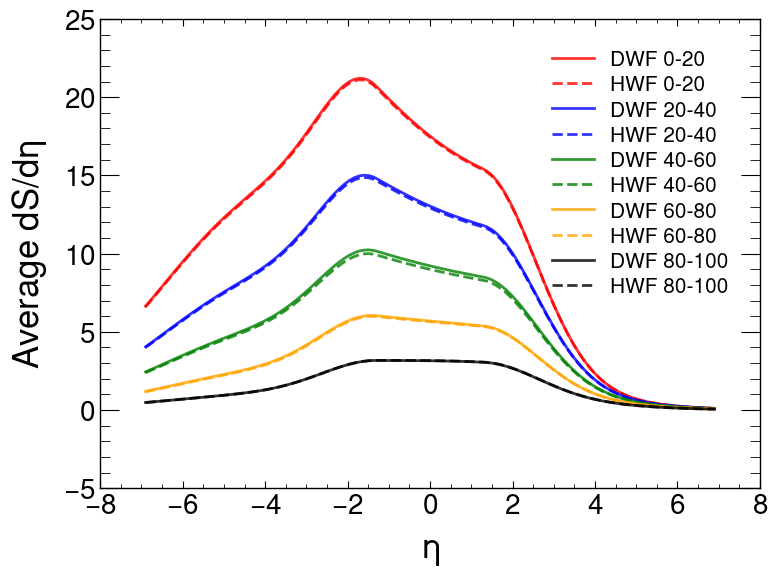

In [17]:
plot_dSdEta_DWF_HWF_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                               eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 50000],
                               L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               num_workers=16,save_fig=False)

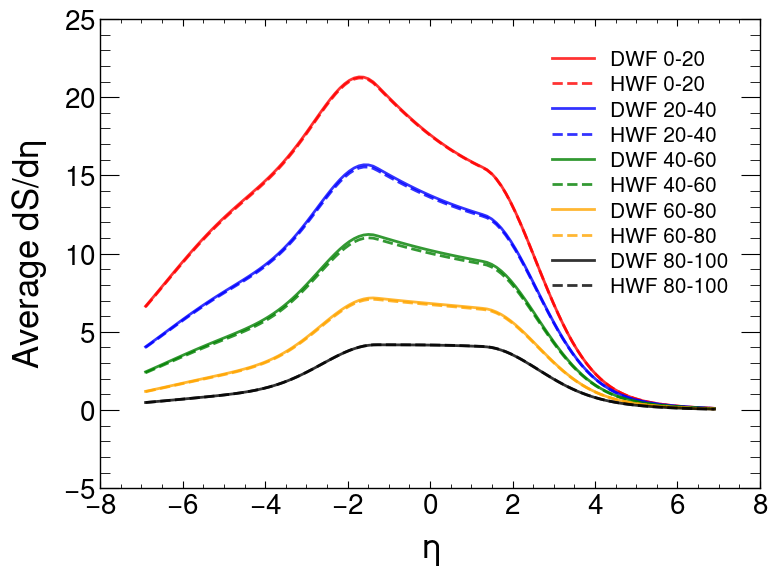

In [19]:
plot_dSdEta_DWF_HWF_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                               eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 50000],
                               L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               num_workers=16,save_fig=True)

In [74]:
def plot_dSdEta_DWF_HWF_comparison_legend(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                   eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                                   L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                                   cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                   num_workers=16,save_fig=False):
    """
    对比 DWF 和 HWF 参数下的 dS/dEta 平均分布，并将它们绘制在同一张图中。
    """
    def calculate_and_sort(HWF_or_DWF):
        # 计算器
        calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                      y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                      L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)
        
        # 输入文件路径
        input_dir = (f'/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')
        
        # 计算所有事件的 dSdEta
        dSdEta_event_ds_total = []
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                       for event in range(event_range[0], event_range[1])}

            for future in as_completed(futures):
                event = futures[future]
                try:
                    dSdEta_result = future.result()
                    if dSdEta_result is not None:
                        etas = np.linspace(-eta, eta, slices)
                        ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                        dSdEta_event_ds_total.append([dSdEta_result, event, ds_total])
                except Exception as e:
                    print(f"Error processing event {event}: {e}")

        # 排序
        dSdEta_event_ds_total_array = np.array(dSdEta_event_ds_total, dtype=object)
        sorted_indices = np.argsort(dSdEta_event_ds_total_array[:, 2])[::-1]
        dSdEta_event_ds_total_array = dSdEta_event_ds_total_array[sorted_indices]
        return dSdEta_event_ds_total_array[:, 0]  # 返回 dSdEta 数据
    
    # 分别计算 DWF 和 HWF 的结果
    dSdEta_DWF = calculate_and_sort('DWF')
    dSdEta_HWF = calculate_and_sort('HWF')

    # 生成快度坐标
    eta_values = np.linspace(-eta, eta, slices)

    # 绘图
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    plt.figure(figsize=(8, 6))
    color_idx=0
    
    # Create custom legend handles first
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='-', lw=2, label='DWF'),
        Line2D([0], [0], color='black', linestyle='--', lw=2, label='HWF')
    ]
    
    for (start, end), color in zip(cents, colors):
        # 获取 DWF 和 HWF 的平均分布
        DWF_start_idx = int(len(dSdEta_DWF) * start / 100)
        DWF_end_idx = int(len(dSdEta_DWF) * end / 100)
        avg_DWF = np.mean(dSdEta_DWF[DWF_start_idx:DWF_end_idx], axis=0)

        HWF_start_idx = int(len(dSdEta_HWF) * start / 100)
        HWF_end_idx = int(len(dSdEta_HWF) * end / 100)
        avg_HWF = np.mean(dSdEta_HWF[HWF_start_idx:HWF_end_idx], axis=0)

        # 绘制 DWF 和 HWF 曲线
        plt.plot(eta_values, avg_DWF, color=color, linestyle='-', alpha=0.8)
        plt.plot(eta_values, avg_HWF, color=color, linestyle='--', alpha=0.8)

        # 计算标签的 y 位置（0-20% 最高，80-100% 最低）
        y_pos = avg_DWF[len(avg_DWF)//2]  # 默认取中间值
        if (start, end) == (0, 20):
            y_pos += 3  # 0-20% 标签比曲线高 2.0
        elif (start, end) == (80, 100):
            y_pos += 1.0  # 80-100% 标签仅比曲线高 0.2
        else:
            # 中间的中心度按比例调整
            cent_mid = (start + end) / 2
            y_pos += 2.0 - (cent_mid / 50)  # 线性递减

        # 添加中心度标签
        plt.text(0, y_pos, f'{start}-{end}%', 
                 color=color, fontsize=16, ha='center', va='center')
        
    # 添加标签和图例
    plt.xlabel(r'$\rm \eta$', fontsize=25, ha='center')
    plt.ylabel(r'Average $\rm dS/d\eta$', fontsize=25, ha='center')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    # Add the custom legend
    plt.legend(handles=legend_elements, fontsize=20, loc='upper right')
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'fig/Average_dSdeta_DWF_HWF_0p5_new.pdf', bbox_inches='tight')
    plt.show()

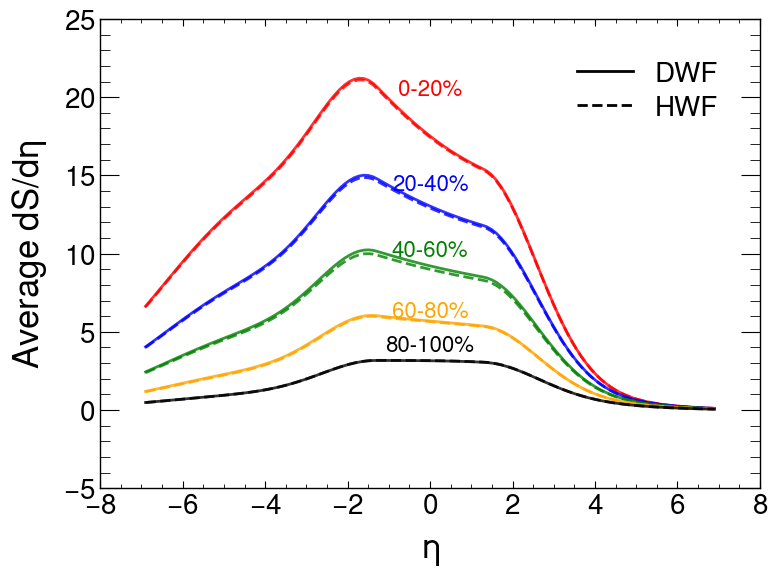

In [75]:
plot_dSdEta_DWF_HWF_comparison_legend(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                               eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 50000],
                               L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               num_workers=16,save_fig=True)

# 尝试找到比较好的参数去拟合流体结果
### 按照先前的经验，我们有一个预想的结果

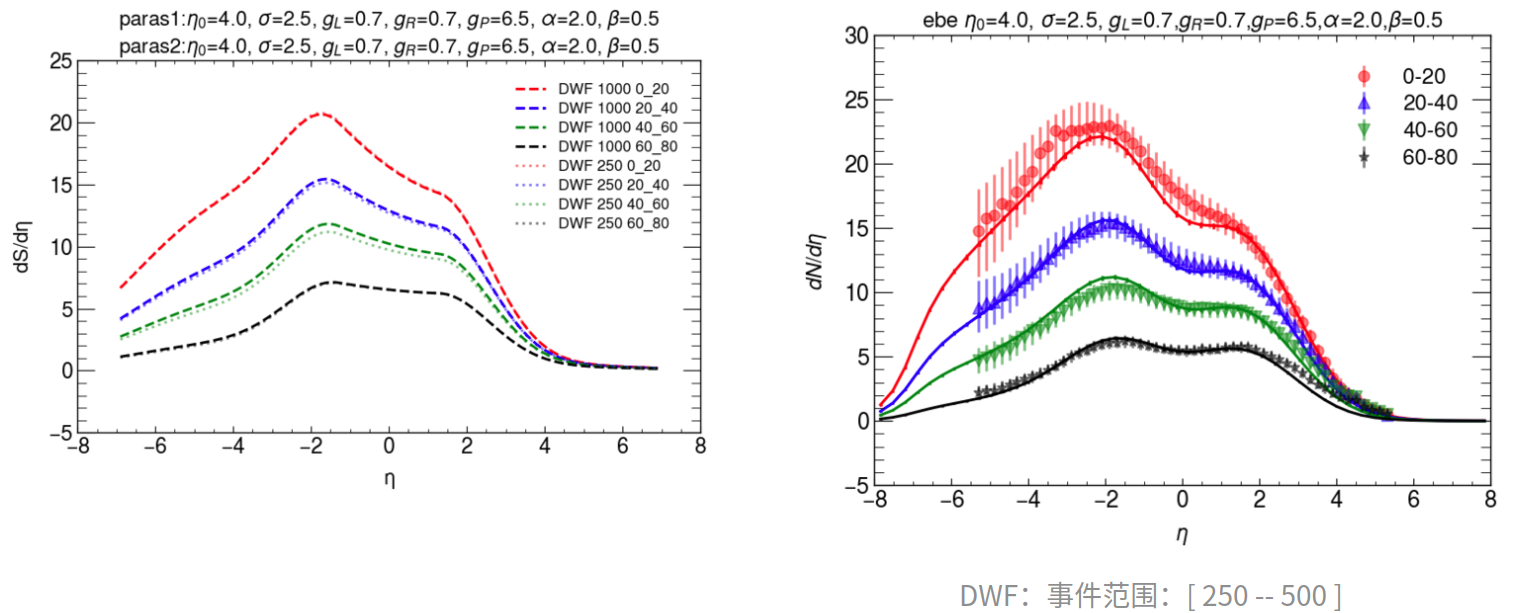

### 我们尝试将先前的dSdEta结果提取出来，重新拟合参数

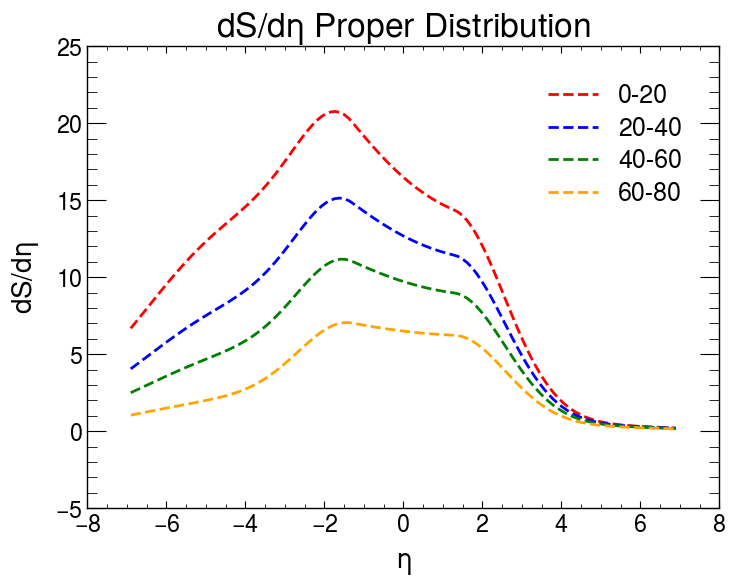

In [18]:
# 导入先前的合适的dSdEta分布的数据
dSdEta_proper = np.loadtxt("./data/dSdEta_list_proper.dat")

def plot_dEdEta_proper(dSdEta):
    etas = np.linspace(-6.9, 6.9, 121)
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    for i in range(len(dSdEta)):
        plt.plot(etas, dSdEta[i],color=colors[i], label=labels[i],linestyle='--')
    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'$\rm dS/d\eta$ Proper Distribution')
    plt.legend(fontsize=18)
# 画图
plot_dEdEta_proper(dSdEta=dSdEta_proper)

In [19]:
def plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                        eta_flat=1.3, eta_gw=1.3, y_loss=0.0, event_range=[0, 1000],
                                        L_factor=0.7, R_factor=0.7, P_factor=6.5, alpha=2.0, beta=0.5,
                                        HWF_or_DWF='DWF', num_workers=16,
                                        percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                        plot_dSdEta_proper=False):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并绘制不同中心度区间的平均分布。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """

    # 实例化计算器
    calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
                                   y_0=y_0, sigma=sigma, y_loss=y_loss, alpha=alpha, beta=beta,
                                   L_factor=L_factor, R_factor=R_factor, P_factor=P_factor)

    # 输入文件路径
    disk_2T = '74e6f585-9c67-40c0-a5e9-89fb98e77bab'
    input_dir = (f'/media/mengzhu/{disk_2T}/home/mengzhu/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')

    # 并行计算并保存结果
    dSdEta_event_ds_total = []  # 用于保存 dSdEta、事件序号和积分值
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                   for event in range(event_range[0], event_range[1])}

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result = future.result()
                if dSdEta_result is not None:
                    # 计算积分
                    etas = np.linspace(-eta, eta, slices)
                    ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                    # 保存 dSdEta、事件序号和积分值
                    dSdEta_event_ds_total.append([dSdEta_result, event, ds_total])
            except Exception as e:
                print(f"Error processing event {event}: {e}")

    # 转换为 NumPy 数组
    dSdEta_event_ds_total_array = np.array(dSdEta_event_ds_total, dtype=object)

    # 按积分值降序排序
    sorted_indices = np.argsort(dSdEta_event_ds_total_array[:, 2])[::-1]
    dSdEta_event_ds_total_array = dSdEta_event_ds_total_array[sorted_indices]
    dSdEta = dSdEta_event_ds_total_array[:, 0]

    # 调用绘制五个中心度区间平均分布的函数
    # 生成横坐标
    eta_values = np.linspace(-eta, eta, slices)
    
    # 用于存储每个区间的平均分布
    average_distributions = []
    
    # 总事件数
    total_events = len(dSdEta)
    
    # 计算每个区间的平均 dSdEta 分布
    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        
        # 提取对应区间的 dSdEta 数据
        dSdEta_data = np.array([dSdEta[i] for i in range(start_idx, end_idx)])
        
        # 计算平均值
        average_distribution = np.mean(dSdEta_data, axis=0)
#         average_distributions.append((average_distribution, f'{start}-{end}'))
        average_distributions.append(average_distribution)

    
    # 绘图
    plt.figure(figsize=(8, 6))
#     colors = ['blue','orange', 'green','red', 'black', 'purple', 'cyan']
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

    for idx, avg_dist in enumerate(average_distributions):
        plt.plot(eta_values, avg_dist, label=labels[idx], color=colors[idx], linestyle='-',alpha=0.8)
    
    # 画出proper dSdEta 分布
    # 导入先前的合适的dSdEta分布的数据
    if plot_dSdEta_proper:
        dSdEta_proper = np.loadtxt("./data/dSdEta_list_proper.dat")
        for i in range(len(dSdEta_proper)):
            plt.plot(etas, dSdEta_proper[i],label=labels[i]+" period",color=colors[i],linestyle='--',alpha=0.8)
    
    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'$\rm dS/d\eta$ Average Distribution in Different Centralities'
              f'\n$\eta_0$={y_0}, $\sigma$={sigma}, $g_L$={L_factor}, $g_R$={R_factor}, '
        f'$g_P$={P_factor}, $\\alpha$={alpha}, $\\beta$={beta}, $\\Delta \\eta$={y_loss}', fontsize=20)
    plt.legend(fontsize=16, loc='upper right')
    plt.grid()
    plt.show()
    

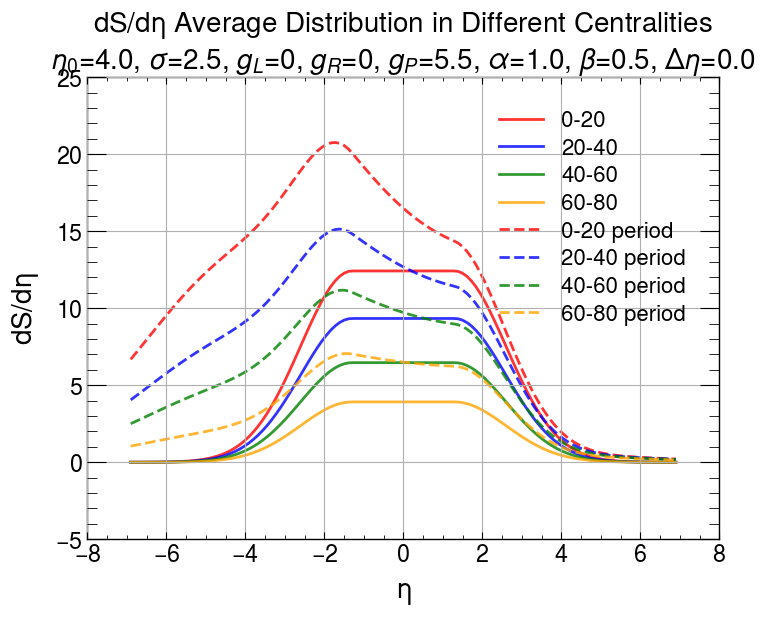

In [20]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=0.0, event_range=[0, 5000],
                                    L_factor=0, R_factor=0, P_factor=5.5, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80)],
                                    plot_dSdEta_proper=True)

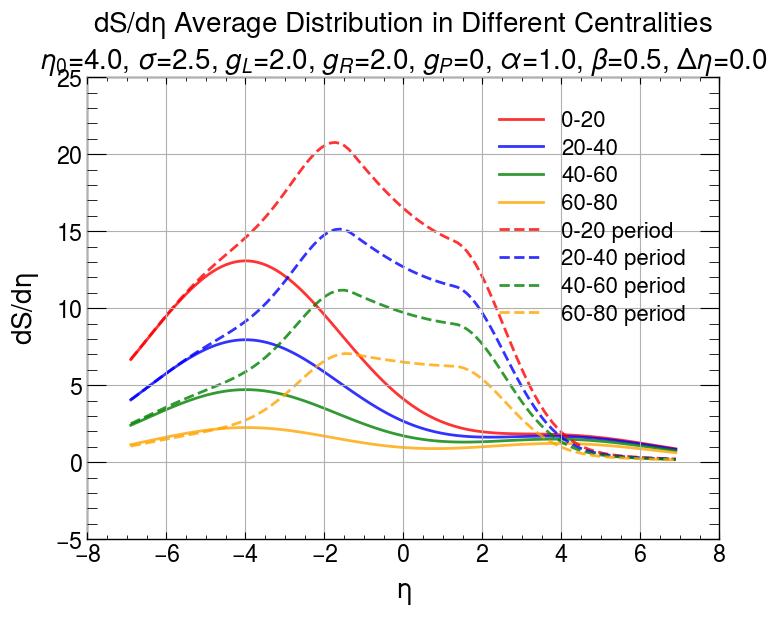

In [21]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=0.0, event_range=[0, 5000],
                                    L_factor=2.0, R_factor=2.0, P_factor=0, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80)],
                                    plot_dSdEta_proper=True)

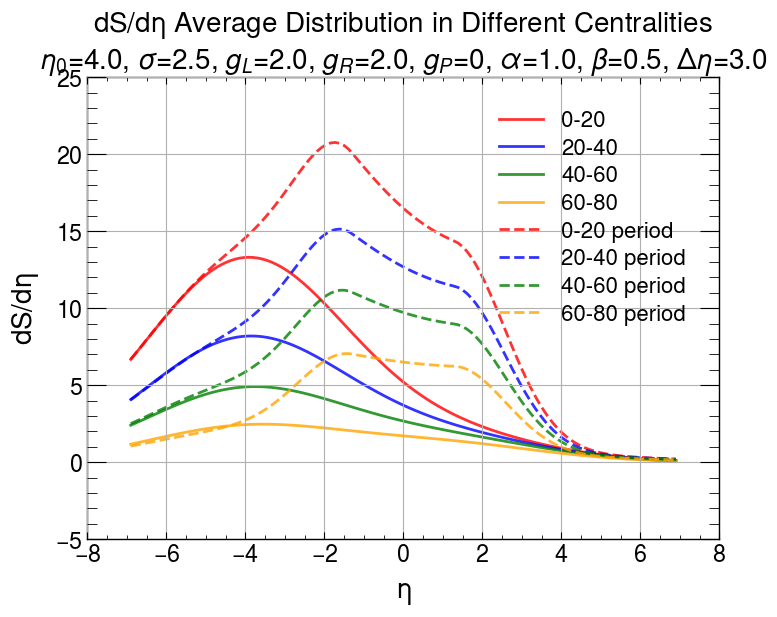

In [22]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                                    L_factor=2.0, R_factor=2.0, P_factor=0, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80)],
                                    plot_dSdEta_proper=True)

### 我们的流体的采用的参数

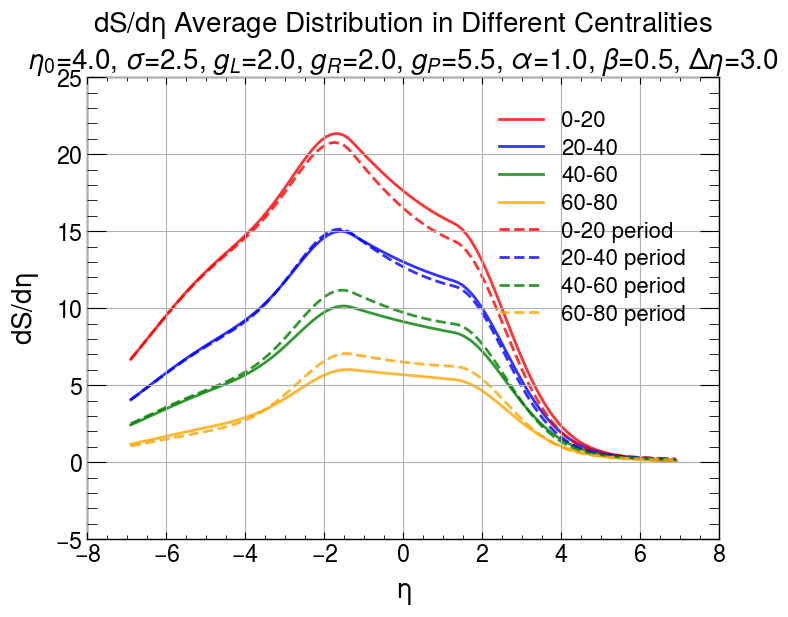

In [23]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80)],
                                    plot_dSdEta_proper=True)

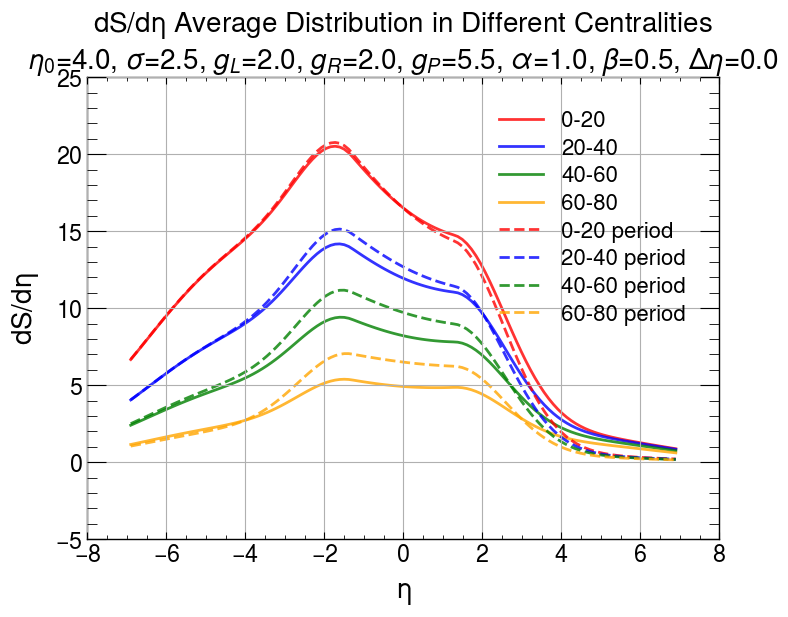

In [24]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=0.0, event_range=[0, 5000],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80)],
                                    plot_dSdEta_proper=True)

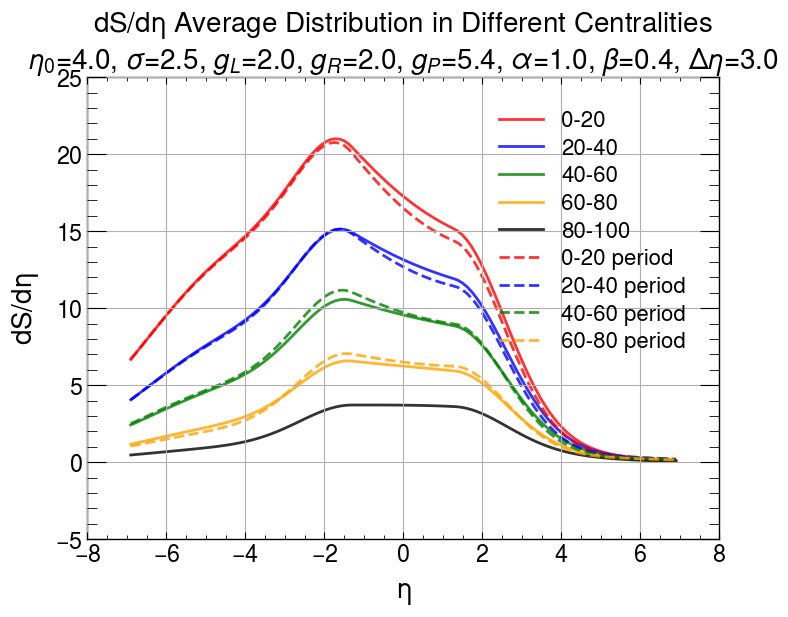

In [25]:
plot_dSdEta_centralities_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, y_loss=3.0, event_range=[0, 5000],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.4,
                                    HWF_or_DWF='DWF', num_workers=16,
                                    percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80,100)],
                                    plot_dSdEta_proper=True)

# 参数：

### $$event_{\text{range}} = [0, 1000],\quad  y_0 = 4.0, \quad \sigma = 2.5, \quad \eta_{\text{flat}} = 1.3, \quad \eta_{\text{gw}} = 1.3, \quad y_{\text{loss}} = 3.0$$ 
### $$\quad L_{\text{factor}} = 2.0, \quad R_{\text{factor}} = 2.0, \quad P_{\text{factor}} = 5.5, \quad \alpha = 1.0, \quad \beta = 0.5$$

### 在上面的参数下，可以得到相对不错的结果  

In [26]:
def plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.5, 4.0], sigma=[2.5, 2.5],
                           eta_flat=[1.3, 1.3], eta_gw=[1.3, 1.3], y_loss=[0.0, 0.0], events=[1000,  1000],
                           L_factor=[0.7, 0.7], R_factor=[0.7, 0.7], P_factor=[6.5, 6.5], alpha=[2.0, 2.0], beta=[0.5, 0.5],
                           HWF_or_DWF='DWF', num_workers=16,
                           percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]):
    """
    比较不同参数设置下的 dSdEta 分布。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 参数列表，用于对比
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """
    
    # 对输入的参数进行处理，找到不变的参数用于标题显示，变化的参数作为label显示
    
    # 提取所有参数
    params_dict = {
        'y_0': y_0, 'sigma': sigma, 'eta_flat': eta_flat, 'eta_gw': eta_gw,
        'y_loss': y_loss, 'L_factor': L_factor, 'R_factor': R_factor,
        'P_factor': P_factor, 'alpha': alpha, 'beta': beta, 'events':events
    }

    # 提取不变参数
    constant_params = {k: v[0] for k, v in params_dict.items() if len(set(v)) == 1}
    constant_params_str = ', '.join([f"{k}={v}" for k, v in constant_params.items()])

    # 提取变化参数
    varying_params_keys = [k for k, v in params_dict.items() if len(set(v)) > 1]

    # 保存两组参数下的结果
    results = []

    param_sets = zip(y_0, sigma, eta_flat, eta_gw, y_loss, events, L_factor, R_factor, P_factor, alpha, beta)
    for idx, (y_0_val, sigma_val, eta_flat_val, eta_gw_val, y_loss_val,
              events_val, L_factor_val, R_factor_val, P_factor_val, alpha_val, beta_val) in enumerate(param_sets):

        # 仅保存变化的参数和值
        varying_params = {key: value[idx] for key, value in params_dict.items() if key in varying_params_keys}

        # 实例化计算器
        calculator = dSdEtaCalculator(eta=eta, slices=slices, eta_flat=eta_flat_val, eta_gw=eta_gw_val,
                                      y_0=y_0_val, sigma=sigma_val, y_loss=y_loss_val, alpha=alpha_val,
                                      beta=beta_val, L_factor=L_factor_val, R_factor=R_factor_val,
                                      P_factor=P_factor_val)

        # 输入文件路径
        disk_2T = '74e6f585-9c67-40c0-a5e9-89fb98e77bab'
        input_dir = (f'/media/mengzhu/{disk_2T}/home/mengzhu/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')


        # 并行计算
        dSdEta_event_ds_total = []
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            futures = {executor.submit(calculate_event_dSdEta, event, input_dir, calculator): event
                       for event in range(0, events_val)}

            for future in as_completed(futures):
                event = futures[future]
                try:
                    dSdEta_result = future.result()
                    if dSdEta_result is not None:
                        etas = np.linspace(-eta, eta, slices)
                        ds_total = calculate_integral(dSdEta_result, etas, method="trapezoid")
                        dSdEta_event_ds_total.append([dSdEta_result, event, ds_total])
                except Exception as e:
                    print(f"Error processing event {event}: {e}")

        # 排序与平均计算
        dSdEta_event_ds_total_array = np.array(dSdEta_event_ds_total, dtype=object)
        sorted_indices = np.argsort(dSdEta_event_ds_total_array[:, 2])[::-1]
        dSdEta_event_ds_total_array = dSdEta_event_ds_total_array[sorted_indices]
        dSdEta = dSdEta_event_ds_total_array[:, 0]

        total_events = len(dSdEta)
        dSdEta_average_distributions = []
        for start, end in percentiles:
            start_idx = int(total_events * start / 100)
            end_idx = int(total_events * end / 100)
            dSdEta_data = np.array([dSdEta[i] for i in range(start_idx, end_idx)])
            dSdEta_average_distribution = np.mean(dSdEta_data, axis=0)
            dSdEta_average_distributions.append(dSdEta_average_distribution)

        # 保存结果：多个中心度的平均的dSdEta分布和变化参数
        results.append((dSdEta_average_distributions, varying_params))
        
    # 绘图
    plt.figure(figsize=(10, 8))
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    linestyles = ['-', '--']
    
    # 对字符串latex化
    def format_to_latex(param_dict):
        """
        将参数名替换为LaTeX格式的希腊字母。
        """
        latex_replacements = {
            'alpha': r'\rm \alpha', 'beta': r'\rm \beta', 'eta': r'\rm \eta', 'sigma': r'\rm \sigma',
            'y_0': r'\rm y_0', 'y_loss': r'\rm \Delta_{\rm \eta}', 'P_factor': r'\rm P_{\rm factor}',
            'L_factor': r'\rm L_{\rm factor}', 'R_factor': r'\rm R_{\rm factor}',
            'eta_flat': r'\rm \eta_{\rm flat}', 'eta_gw': r'\rm \eta_{\rm gw}', 'events': r'\rm N_{\rm {events}}'
        }
        formatted_params = []
        for key, value in param_dict.items():
            latex_key = latex_replacements.get(key, key)  # 替换为LaTeX格式，如果找不到则保持原样
            formatted_params.append(f"{latex_key}={value}")
        return ', '.join(formatted_params)

    # 绘图部分
    etas = np.linspace(-eta, eta, slices)
    for idx, (avg_dists, varying_params) in enumerate(results):
        for pct_idx, avg_dist in enumerate(avg_dists):
            # 将变化的参数和值转换为LaTeX格式
            varying_params_str = format_to_latex(varying_params)
            label = f"${varying_params_str}$, {percentiles[pct_idx][0]}-{percentiles[pct_idx][1]}"
            plt.plot(etas, avg_dist, label=label, color=colors[pct_idx], linestyle=linestyles[idx])

    # 主标题
    constant_params_str = format_to_latex(constant_params)
    plt.title(r'Comparison of $\rm dS/d\eta$ for Different Parameters' + '\n' + f"${constant_params_str}$", fontsize=20)
    plt.xlabel(r'$\rm \eta$', fontsize=20,ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20,ha='center')
    plt.legend(fontsize=16, loc='upper right')
    plt.grid()
    plt.show()


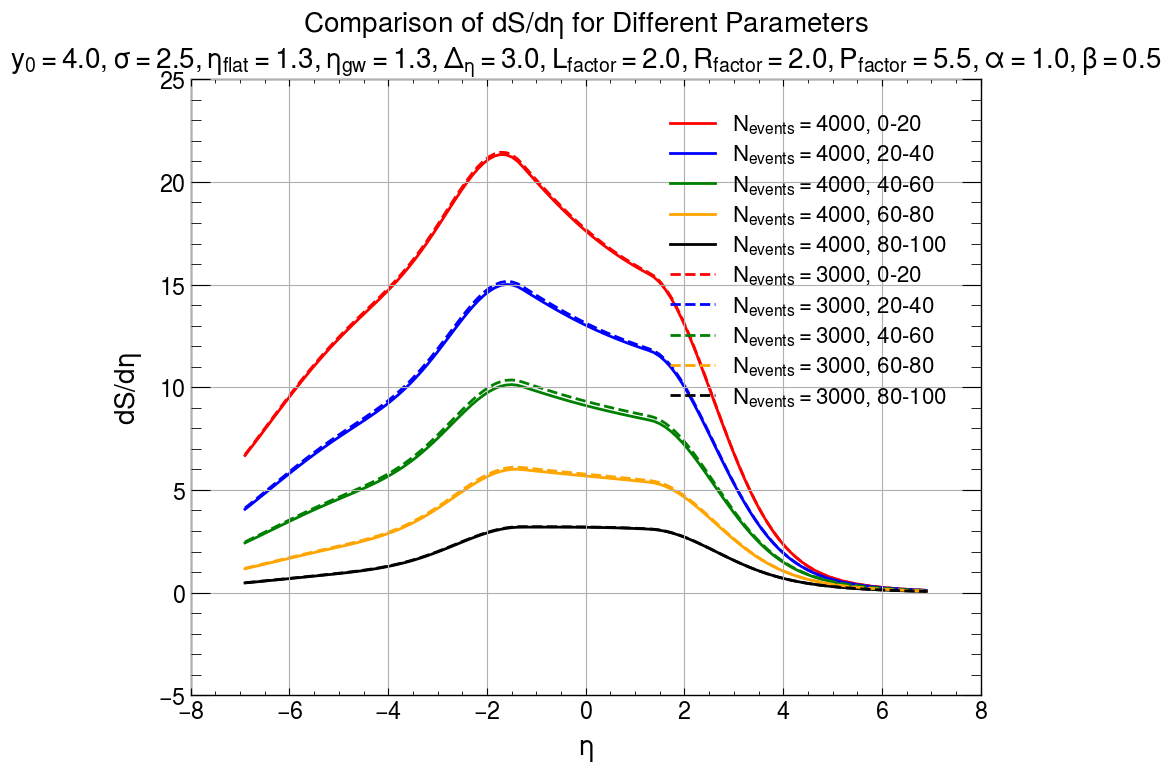

In [27]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[4000, 3000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.5,5.5], alpha=[1.0,1.0], beta=[0.5,0.5],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])


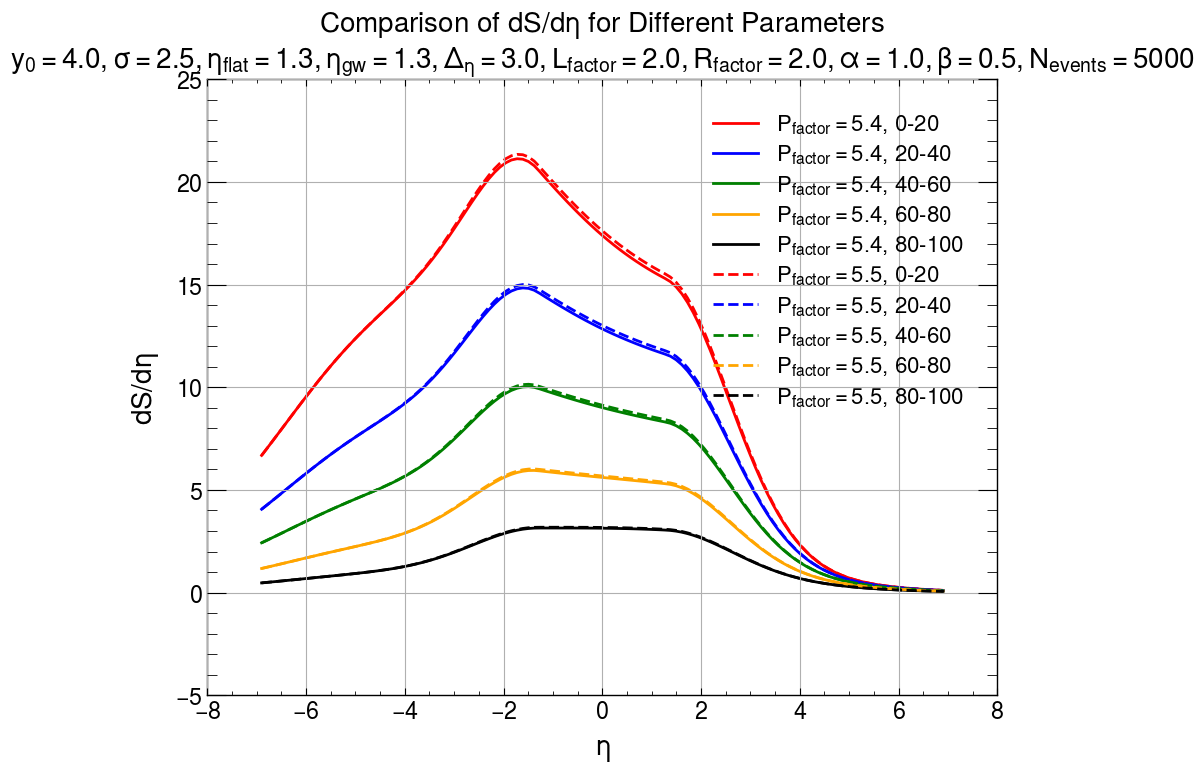

In [28]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[5000, 5000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.4,5.5], alpha=[1.0,1.0], beta=[0.5,0.5],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])


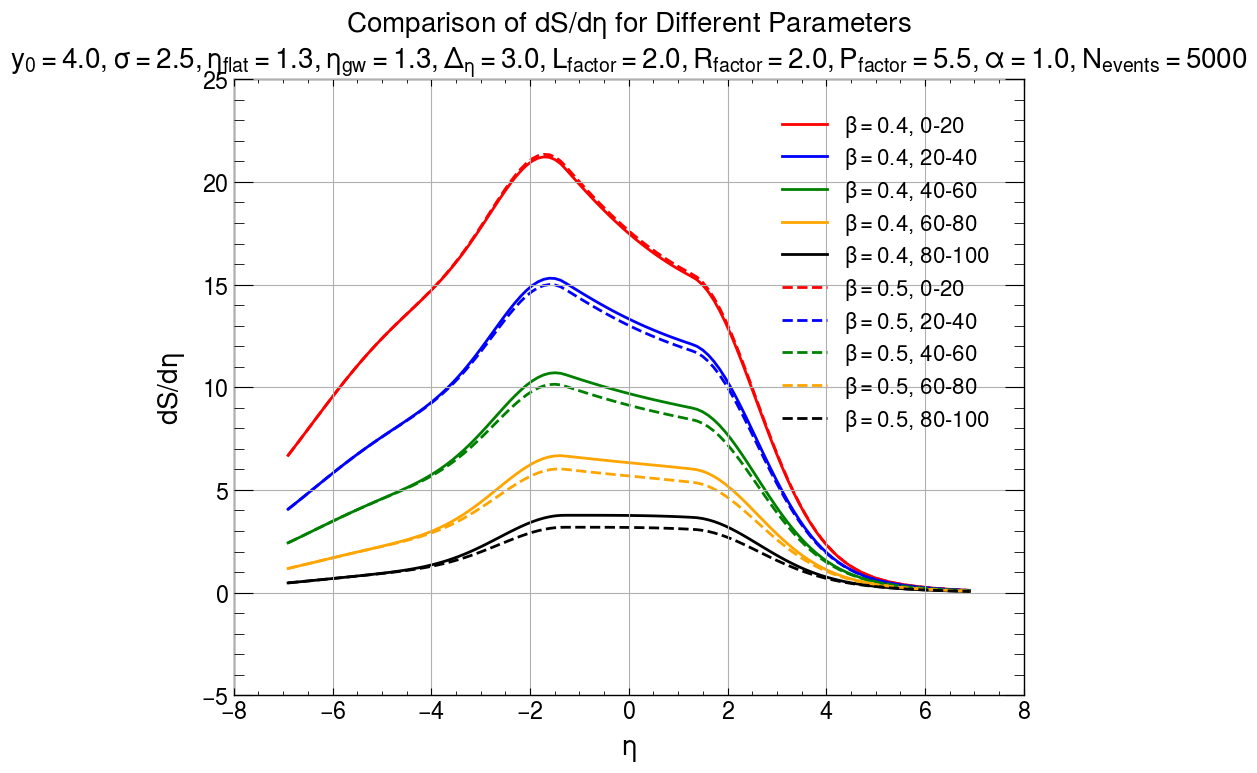

In [29]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[5000, 5000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.5,5.5], alpha=[1.0,1.0], beta=[0.4,0.5],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])


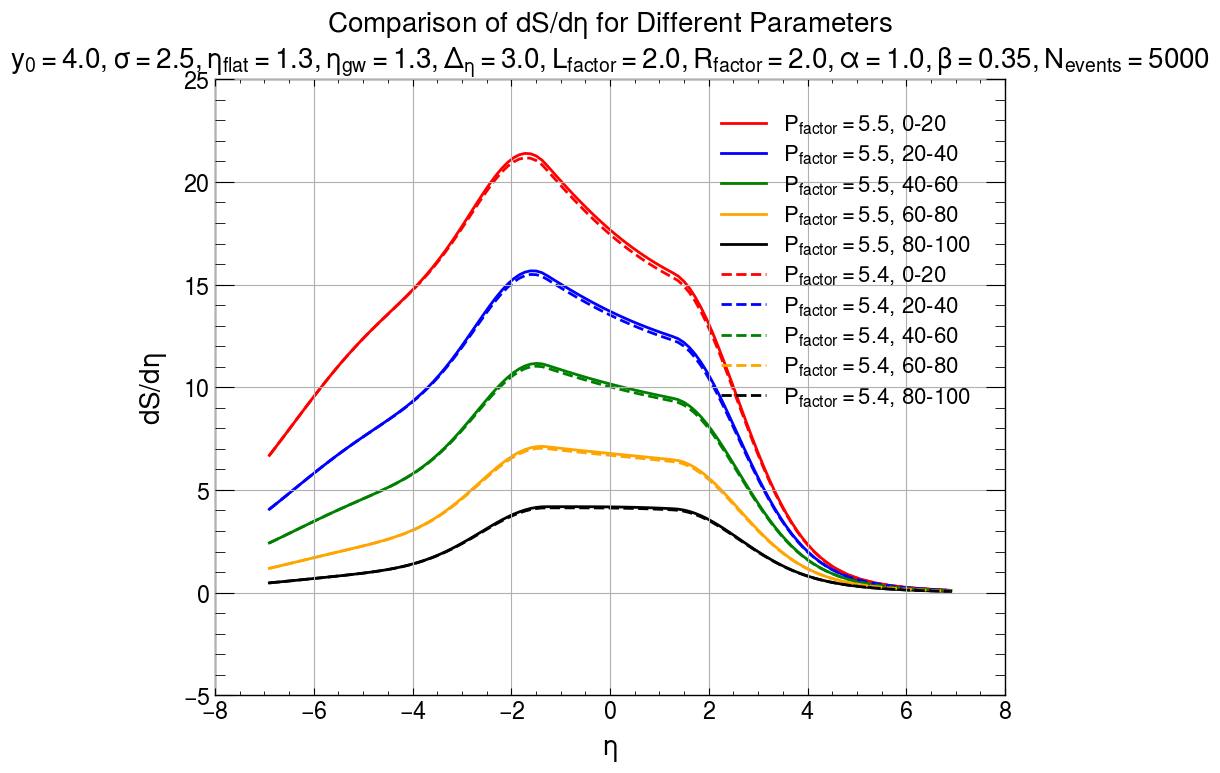

In [30]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[5000, 5000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.5,5.4], alpha=[1.0,1.0], beta=[0.35,0.35],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])


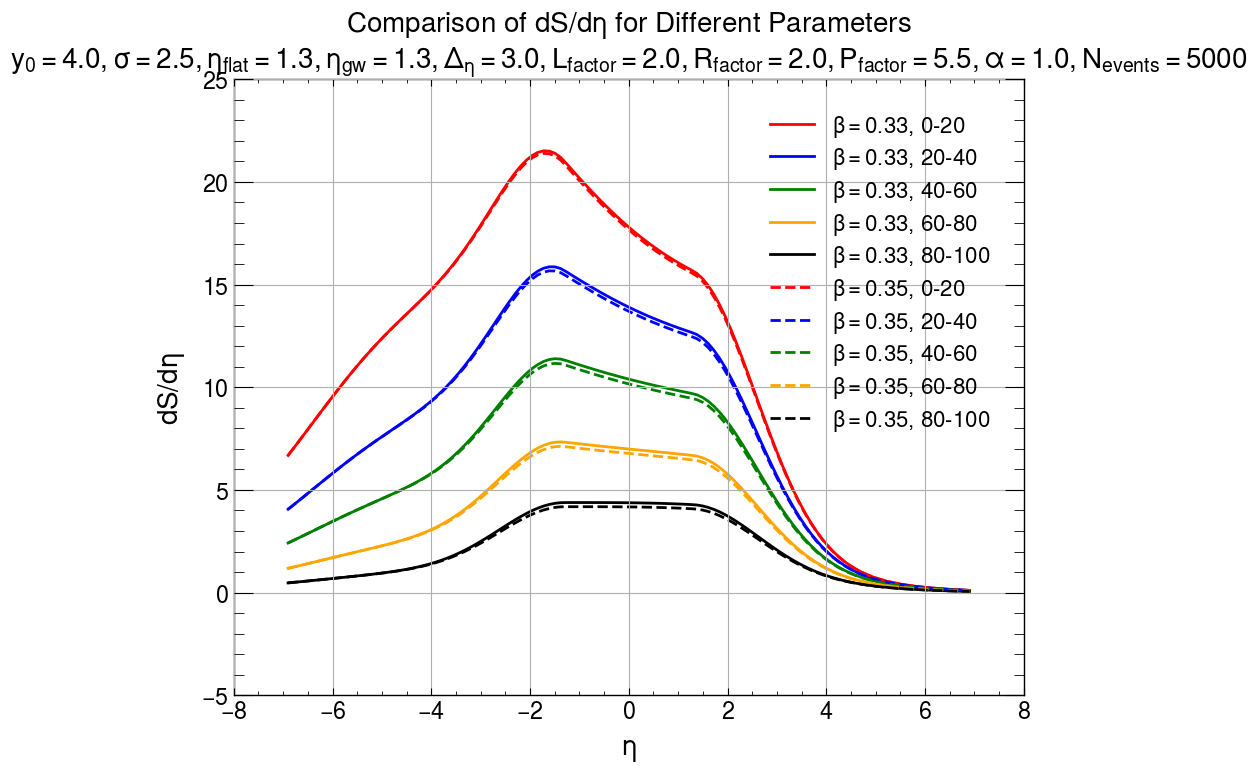

In [31]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[5000, 5000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.5,5.5], alpha=[1.0,1.0], beta=[0.33,0.35],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])


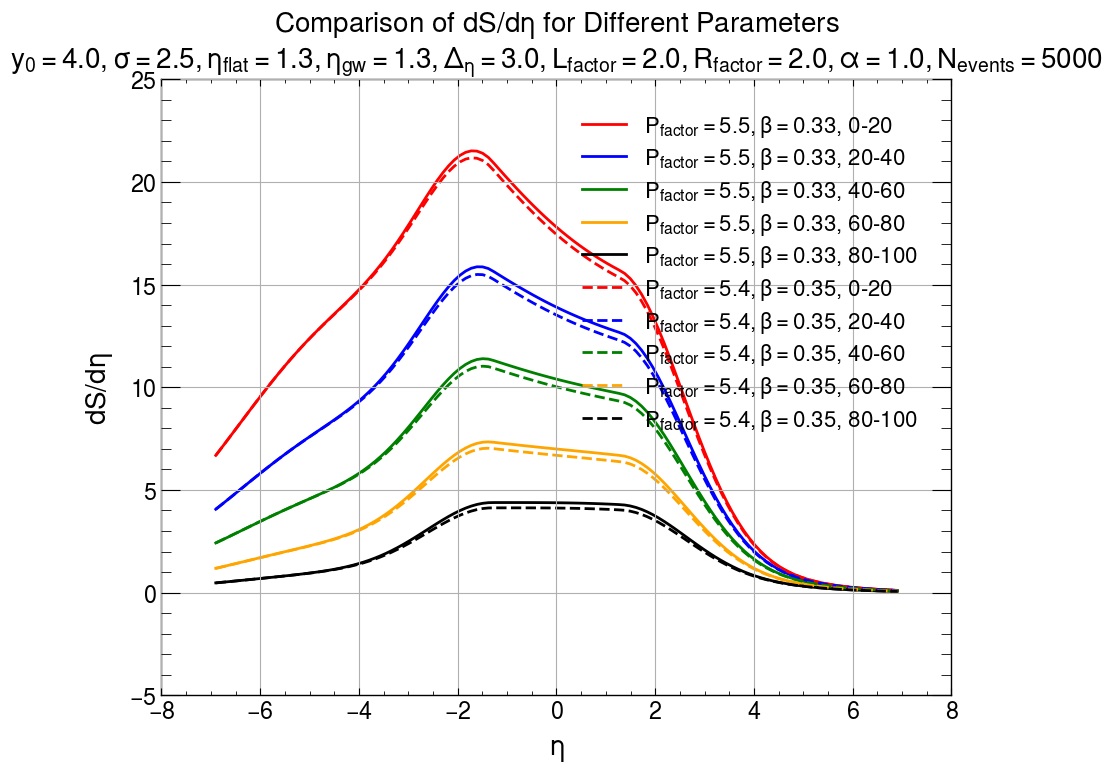

In [32]:
plot_dSdEta_comparison(eta=6.9, slices=121, y_0=[4.0, 4.0], sigma=[2.5, 2.5],
                       eta_flat=[1.3,1.3], eta_gw=[1.3,1.3], y_loss=[3.0,3.0], events=[5000, 5000],
                       L_factor=[2.0,2.0], R_factor=[2.0,2.0], P_factor=[5.5,5.4], alpha=[1.0,1.0], beta=[0.33,0.35],
                       HWF_or_DWF='DWF', num_workers=16,
                       percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)])
